# Traitement des données sur les animaux

In [141]:
# Import des librairies nécessaires

import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import class_weight, shuffle
from sklearn.preprocessing import LabelEncoder

# Pour le modèle, utilisons Keras et Tensorflow
from keras import applications
from keras import optimizers
from keras.utils import to_categorical
from keras.models import Sequential, Model, load_model
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

Les photos des animaux sont stockées dans un dossier `raw-img`, qui contient plusieurs sous-dossiers avec des images de différents animaux :
- butterfly (papillons)
- cat (chats)
- chicken (poules)
- cow (vaches)
- dog (chiens)
- elephant (éléphants)
- horse (chevaux)
- sheep (moutons)
- spider (araignées)
- squirrel (écureuils)

In [142]:
image_folder_names = os.listdir("./raw-img/")
categories = []
filenames = []

# On récupère les noms des dossiers et des fichiers
for folder in image_folder_names:
    for filename in os.listdir(f"./raw-img/{folder}"):
        categories.append(folder)
        filenames.append(f"./raw-img/{folder}/{filename}")

# Voyons toutes les catégories récupérées...
print(list(set(categories)))

# ... et le nombre de fichiers récupérés
print(f"{len(filenames)} fichiers récupérés.")

['chicken', 'horse', 'cow', 'butterfly', 'spider', 'elephant', 'dog', 'squirrel', 'cat', 'sheep']
26179 fichiers récupérés.


In [143]:
# On crée un DataFrame avec les noms des fichiers et des catégories
df = pd.DataFrame({
    "filename": filenames,
    "category": categories
})

df

,filename,category
0,./raw-img/butterfly/e030b20928e90021d85a5854ee...,butterfly
1,./raw-img/butterfly/e030b20929e90021d85a5854ee...,butterfly
2,./raw-img/butterfly/e030b2092be90021d85a5854ee...,butterfly
3,./raw-img/butterfly/e030b2092ce90021d85a5854ee...,butterfly
4,./raw-img/butterfly/e030b2092de90021d85a5854ee...,butterfly
...,...,...
26174,./raw-img/squirrel/OIP-_U7JiIoYjbWPqmmmmdsvJwH...,squirrel
26175,./raw-img/squirrel/OIP-_VBkNQd_MZI4xoemUb-FtAH...,squirrel
26176,./raw-img/squirrel/OIP-_WyHKgREia-4VijlL6DNswH...,squirrel
26177,./raw-img/squirrel/OIP-_xFGMN0UbYduHdiXQ1maZAH...,squirrel


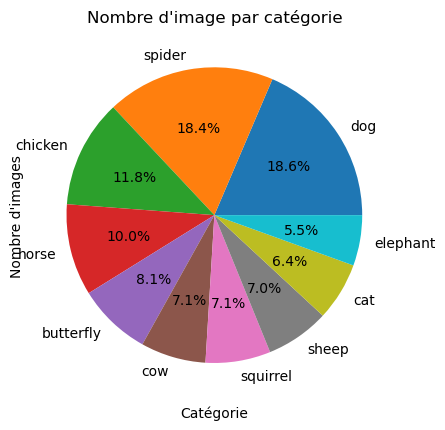

In [144]:
df["category"].value_counts().plot(kind="pie", autopct="%1.1f%%")
plt.xlabel("Catégorie")
plt.ylabel("Nombre d'images")
plt.title("Nombre d'image par catégorie")
plt.show()

In [145]:
# Utilisons un LabelEncoder pour transformer les catégories en valeurs numériques
le = LabelEncoder()

df["category"] = le.fit_transform(df["category"])
df

,filename,category
0,./raw-img/butterfly/e030b20928e90021d85a5854ee...,0
1,./raw-img/butterfly/e030b20929e90021d85a5854ee...,0
2,./raw-img/butterfly/e030b2092be90021d85a5854ee...,0
3,./raw-img/butterfly/e030b2092ce90021d85a5854ee...,0
4,./raw-img/butterfly/e030b2092de90021d85a5854ee...,0
...,...,...
26174,./raw-img/squirrel/OIP-_U7JiIoYjbWPqmmmmdsvJwH...,9
26175,./raw-img/squirrel/OIP-_VBkNQd_MZI4xoemUb-FtAH...,9
26176,./raw-img/squirrel/OIP-_WyHKgREia-4VijlL6DNswH...,9
26177,./raw-img/squirrel/OIP-_xFGMN0UbYduHdiXQ1maZAH...,9


In [146]:
# Créons un DataFrame avec 500 images de chaque catégorie
train_df = pd.DataFrame(columns=["filename", "category"])
frames = []

for i in range(10):
    frames.append(df[df.category == i].iloc[:500, :])

train_df = pd.concat(frames, ignore_index=True)
train_df

,filename,category
0,./raw-img/butterfly/e030b20928e90021d85a5854ee...,0
1,./raw-img/butterfly/e030b20929e90021d85a5854ee...,0
2,./raw-img/butterfly/e030b2092be90021d85a5854ee...,0
3,./raw-img/butterfly/e030b2092ce90021d85a5854ee...,0
4,./raw-img/butterfly/e030b2092de90021d85a5854ee...,0
...,...,...
4995,./raw-img/squirrel/OIP-DLuAMgbGGOGW0r49pIsMtgH...,9
4996,./raw-img/squirrel/OIP-DlVY-0x9uqexVnZY_1TXxgH...,9
4997,./raw-img/squirrel/OIP-DlwICIPtlrWDrdz6v-QVCQH...,9
4998,./raw-img/squirrel/OIP-DL_IigTXGyMfa6OEnyQF3QH...,9


In [147]:
# Mélangeons les données

x = train_df["filename"]
y = train_df["category"]

x, y = shuffle(x, y, random_state=8)

In [148]:
def centering_image(img):
    """Centrer une image
    
    Arguments:
        img {np.array} -- Image à centrer"""
    size = [256,256]

    img_size = img.shape[:2]

    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img

    return resized

In [149]:
images = []

# Redimensionnement des images
for i, file_path in enumerate(train_df.filename.values):
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if(img.shape[0] > img.shape[1]):
        tile_size = (int(img.shape[1] * 256 / img.shape[0]), 256)
    else:
        tile_size = (256, int(img.shape[0] * 256 / img.shape[1]))

    img = centering_image(cv2.resize(img, dsize=tile_size))

    img = img[16:240, 16:240]
    images.append(img)

images = np.array(images)

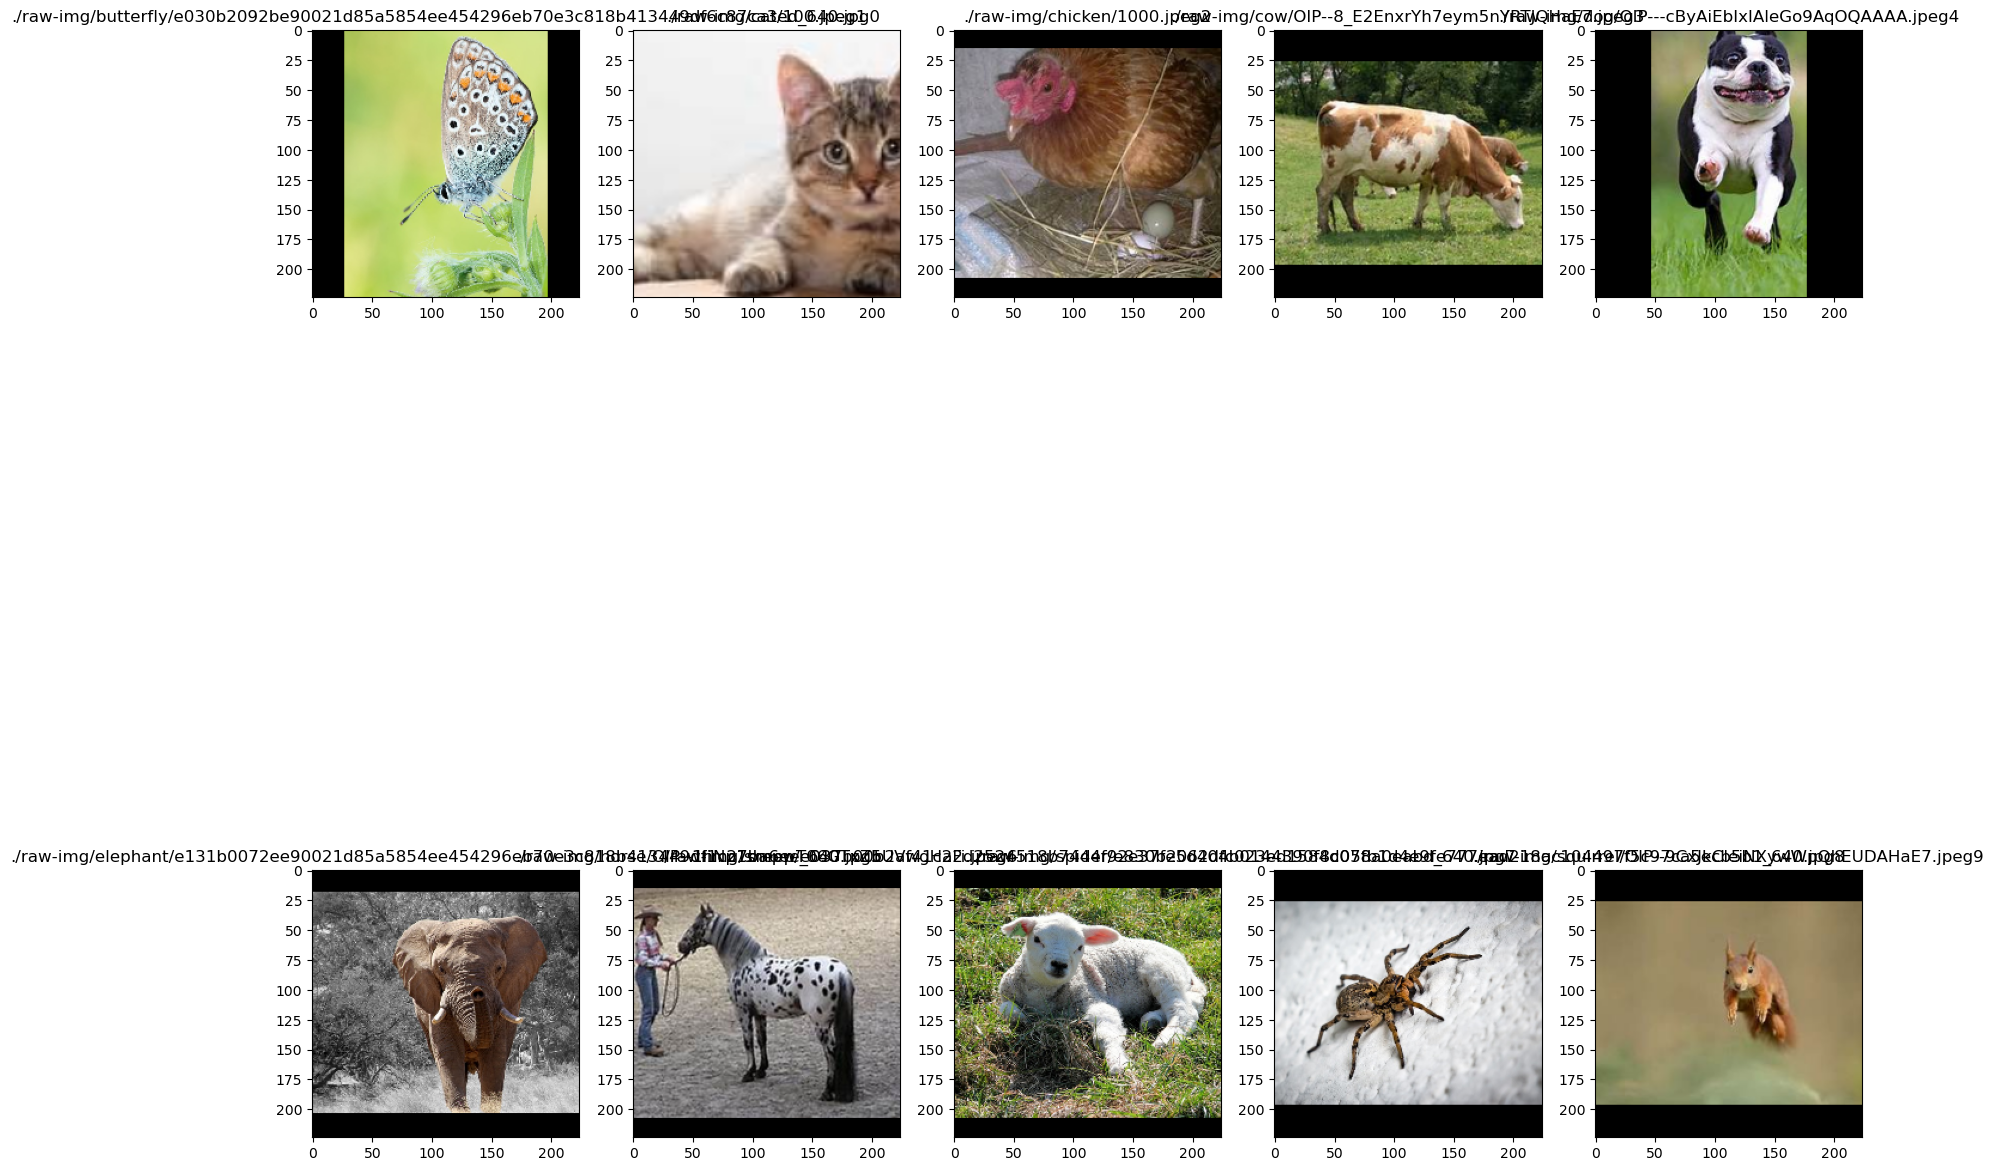

In [150]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,20))
for i in range(10):
    path = train_df[train_df.category == i].values[2]

    axes[i//5, i%5].set_title(path[0] + str(path[1]))
    axes[i//5, i%5].imshow(images[train_df[train_df.filename == path[0]].index[0]])

In [151]:
# Permutation aléatoire des indices
data_num = len(y)
random_index = np.random.permutation(data_num)

# Création des listes x et y mélangées
x_shuffle = []
y_shuffle = []
for i in range(data_num):
    x_shuffle.append(images[random_index[i]])
    y_shuffle.append(y[random_index[i]])

In [152]:
# Conversion des listes en tableaux numpy
x = np.array(x_shuffle) 
y = np.array(y_shuffle)

In [153]:
# Séparation des données en données d'entraînement et de test
val_split_num = int(round(0.2 * len(y))) # 20% des données pour le test
x_train = x[val_split_num:]
y_train = y[val_split_num:]
x_test = x[:val_split_num]
y_test = y[:val_split_num]

In [154]:
# 
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

x_train (4000, 224, 224, 3)
y_train (4000,)
x_test (1000, 224, 224, 3)
y_test (1000,)


In [155]:
# Conversion des images en float32 et normalisation
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255

In [156]:
img_rows, img_cols, img_channel = 224, 224, 3
name_animal = []